In [1]:
import numpy as np

from collections import Counter, defaultdict
from itertools import chain, cycle
from functools import partial

In [2]:
sample_size = 15000
products = ["A", "B", "C", "D"]
totals = [15, 10, 15, 10]
# totals = [10, 10, 10, 10]
flush_lock = 25
transition_lock = 0

In [3]:
def generate_batches_weighted(batch_size, products, totals, sample_size):
    sizes = (np.ceil(np.array(totals) / np.min(totals)) * batch_size).astype(int).tolist()
    iterators = [[product]*size for product, size in zip(products, sizes)]
    base = cycle(chain(*iterators))
    return list(dict(zip(range(sample_size), base)).values())

In [4]:
def generate_batches_unweighted(batch_size, products, totals, sample_size):
    iterators = [[product]*batch_size for product in products]
    base = cycle(chain(*iterators))
    return list(dict(zip(range(sample_size), base)).values())

In [5]:
denominator = sum(totals)
sequence1 = np.random.choice(products, size=sample_size, p=[t/denominator for t in totals]).tolist()

sequence2 = np.random.choice(products, size=sample_size).tolist()

sequence3 = generate_batches_weighted(100, products, totals, sample_size)

sequence4 = generate_batches_unweighted(100, products, totals, sample_size)

sequence5 = generate_batches_weighted(200, products, totals, sample_size)

sequence6 = generate_batches_unweighted(200, products, totals, sample_size)

In [6]:
assert len(sequence1) == sample_size
assert len(sequence2) == sample_size
assert len(sequence3) == sample_size

In [7]:
print(Counter(sequence1))
print(Counter(sequence2))
print(Counter(sequence3))

Counter({'C': 4484, 'A': 4467, 'D': 3055, 'B': 2994})
Counter({'C': 3848, 'A': 3755, 'D': 3700, 'B': 3697})
Counter({'A': 5000, 'C': 5000, 'B': 2500, 'D': 2500})


In [8]:
def no_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return machine_tuple[0]

def sum_of_product_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return sum(machine_tuple[1].values())

def product_count_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return machine_tuple[1][product]

def double_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return (machine_tuple[1][product], sum(machine_tuple[1].values()))

In [9]:
def simulate(
    num_of_machines,
    sequence,
    products,
    totals,
    flush_lock,
    transition_lock,
    priority,
    reverse=True
):

    mix = dict(zip(products, totals))
    machines = {i: defaultdict(int) for i in range(num_of_machines)}
    flushes = defaultdict(int)
    trash = []

    for product in sequence:

        consumed = False
        for i, mach in sorted(machines.items(), key=partial(priority, product=product), reverse=reverse):
            
            # Machine is available to accept products
            machine_is_available = machines[i]["lock"] == 0
            
            # Machine has space to accept product
            product_fits = machines[i][product] < mix[product]
            
            # Complete cases for 3 binary variables
            if not consumed and machine_is_available and product_fits:
                machines[i][product] += 1
                machines[i]["lock"] = transition_lock
                consumed = True
            
            elif not consumed and machine_is_available and not product_fits:
                continue
    
            elif not consumed and not machine_is_available and product_fits:
                machines[i]["lock"] -= 1
    
            elif not consumed and not machine_is_available and not product_fits:
                machines[i]["lock"] -= 1
    
            elif consumed and machine_is_available and product_fits:
                continue
    
            elif consumed and machine_is_available and not product_fits:
                continue
    
            elif consumed and not machine_is_available and product_fits:
                machines[i]["lock"] -= 1
    
            elif consumed and not machine_is_available and not product_fits:
                machines[i]["lock"] -= 1
                
            
        # Trash un-consumed products
        if not consumed:
            trash.append(product)

        # Flush ready machines
        for j in machines:
            if all(machines[j][p] == mix[p] for p in products):
                machines[j] = defaultdict(int)
                machines[j]["lock"] = flush_lock
                flushes[j] += 1
    
    return {
        "trash": len(trash), 
        "total": len(sequence), 
        "consumed": len(sequence) - len(trash),
        "flushes": dict(flushes),
        "actually_flushed" : sum(dict(flushes).values()) * sum(mix.values())
    }

In [10]:
print(simulate(5, sequence1, products, totals, flush_lock, transition_lock, no_priority, reverse=False))
print(simulate(5, sequence2, products, totals, flush_lock, transition_lock, no_priority, reverse=False))
print(simulate(5, sequence3, products, totals, flush_lock, transition_lock, no_priority, reverse=False))
print()
print(simulate(5, sequence1, products, totals, flush_lock, transition_lock, double_priority, reverse=True))
print(simulate(5, sequence2, products, totals, flush_lock, transition_lock, double_priority, reverse=True))
print(simulate(5, sequence3, products, totals, flush_lock, transition_lock, double_priority, reverse=True))

{'trash': 582, 'total': 15000, 'consumed': 14418, 'flushes': {0: 166, 1: 74, 2: 30, 3: 10, 4: 6}, 'actually_flushed': 14300}
{'trash': 2550, 'total': 15000, 'consumed': 12450, 'flushes': {0: 161, 1: 59, 2: 20, 3: 5, 4: 1}, 'actually_flushed': 12300}
{'trash': 6750, 'total': 15000, 'consumed': 8250, 'flushes': {0: 33, 1: 33, 2: 33, 3: 32, 4: 32}, 'actually_flushed': 8150}

{'trash': 280, 'total': 15000, 'consumed': 14720, 'flushes': {0: 72, 1: 71, 2: 68, 3: 55, 4: 27}, 'actually_flushed': 14650}
{'trash': 2387, 'total': 15000, 'consumed': 12613, 'flushes': {0: 71, 1: 70, 2: 63, 3: 36, 4: 10}, 'actually_flushed': 12500}
{'trash': 6700, 'total': 15000, 'consumed': 8300, 'flushes': {0: 33, 1: 33, 2: 33, 3: 33, 4: 33}, 'actually_flushed': 8250}


In [11]:
def averages_of_simulations_consume(num_of_machines, sequence, products, totals, flush_lock, transition_lock, priority, reverse):
    simulations = 1

    rates = []

    for _ in range(simulations):
        data = simulate(num_of_machines, sequence, products, totals, flush_lock, transition_lock, priority, reverse)
        rates.append(data["consumed"]/data["total"])
        
    return np.mean(rates)

In [12]:
def averages_of_simulations_flush(num_of_machines, sequence, products, totals, flush_lock, transition_lock, priority, reverse):
    simulations = 1

    rates = []

    for _ in range(simulations):
        data = simulate(num_of_machines, sequence, products, totals, flush_lock, transition_lock, priority, reverse)
        rates.append(data["actually_flushed"]/data["total"])
        
    return np.mean(rates)

In [13]:
x = list(range(1, 20)) #+ list(range(20, 200, 50))

def get_the_ys_consume(seq):
    return (
    [averages_of_simulations_consume(xx, seq, products, totals, flush_lock, transition_lock, no_priority, reverse=False) for xx in x],
    [averages_of_simulations_consume(xx, seq, products, totals, flush_lock, transition_lock, sum_of_product_priority, reverse=True) for xx in x],
    [averages_of_simulations_consume(xx, seq, products, totals, flush_lock, transition_lock, product_count_priority, reverse=True) for xx in x],
    [averages_of_simulations_consume(xx, seq, products, totals, flush_lock, transition_lock, sum_of_product_priority, reverse=True) for xx in x],
    )


def get_the_ys_flush(seq):
    return (
    [averages_of_simulations_flush(xx, seq, products, totals, flush_lock, transition_lock, no_priority, reverse=False) for xx in x],
    [averages_of_simulations_flush(xx, seq, products, totals, flush_lock, transition_lock, sum_of_product_priority, reverse=True) for xx in x],
    [averages_of_simulations_flush(xx, seq, products, totals, flush_lock, transition_lock, product_count_priority, reverse=True) for xx in x],
    [averages_of_simulations_flush(xx, seq, products, totals, flush_lock, transition_lock, sum_of_product_priority, reverse=True) for xx in x],
    )


# y1 = get_the_ys(sequence1)
# y2 = get_the_ys(sequence2)
# y3 = get_the_ys(sequence3)

In [14]:
from joblib import Parallel, delayed

results_consume = Parallel(n_jobs=3)(delayed(get_the_ys_consume)(i) for i in [sequence1, sequence2, sequence3, sequence4, sequence5, sequence6])

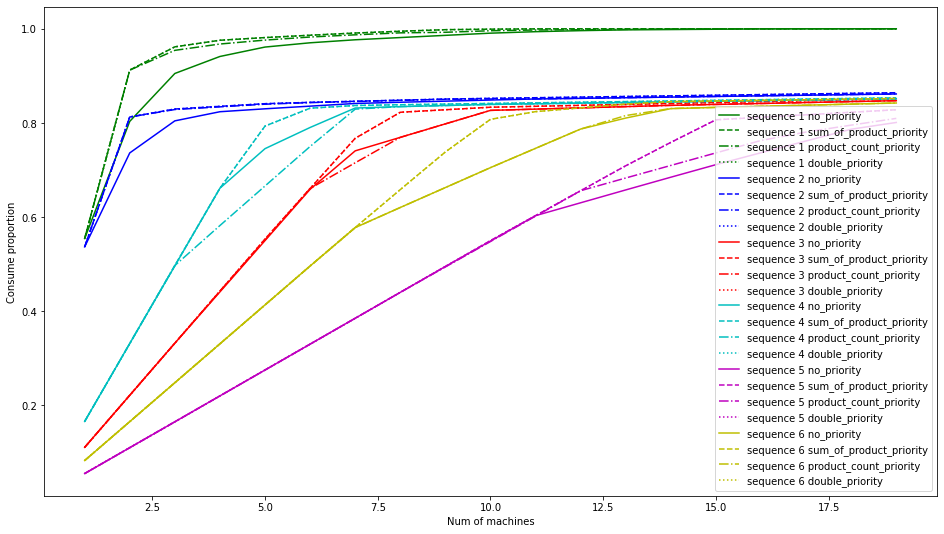

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

plt.plot(x, results_consume[0][0], "-g", label="sequence 1 no_priority")
plt.plot(x, results_consume[0][1], "--g", label="sequence 1 sum_of_product_priority")
plt.plot(x, results_consume[0][2], "-.g", label="sequence 1 product_count_priority")
plt.plot(x, results_consume[0][3], ":g", label="sequence 1 double_priority")

plt.plot(x, results_consume[1][0], "-b", label="sequence 2 no_priority")
plt.plot(x, results_consume[1][1], "--b", label="sequence 2 sum_of_product_priority")
plt.plot(x, results_consume[1][2], "-.b", label="sequence 2 product_count_priority")
plt.plot(x, results_consume[1][3], ":b", label="sequence 2 double_priority")

plt.plot(x, results_consume[2][0], "-r", label="sequence 3 no_priority")
plt.plot(x, results_consume[2][1], "--r", label="sequence 3 sum_of_product_priority")
plt.plot(x, results_consume[2][2], "-.r", label="sequence 3 product_count_priority")
plt.plot(x, results_consume[2][3], ":r", label="sequence 3 double_priority")

plt.plot(x, results_consume[3][0], "-c", label="sequence 4 no_priority")
plt.plot(x, results_consume[3][1], "--c", label="sequence 4 sum_of_product_priority")
plt.plot(x, results_consume[3][2], "-.c", label="sequence 4 product_count_priority")
plt.plot(x, results_consume[3][3], ":c", label="sequence 4 double_priority")

plt.plot(x, results_consume[4][0], "-m", label="sequence 5 no_priority")
plt.plot(x, results_consume[4][1], "--m", label="sequence 5 sum_of_product_priority")
plt.plot(x, results_consume[4][2], "-.m", label="sequence 5 product_count_priority")
plt.plot(x, results_consume[4][3], ":m", label="sequence 5 double_priority")

plt.plot(x, results_consume[5][0], "-y", label="sequence 6 no_priority")
plt.plot(x, results_consume[5][1], "--y", label="sequence 6 sum_of_product_priority")
plt.plot(x, results_consume[5][2], "-.y", label="sequence 6 product_count_priority")
plt.plot(x, results_consume[5][3], ":y", label="sequence 6 double_priority")


plt.xlabel("Num of machines")
plt.ylabel("Consume proportion")

plt.legend()
plt.show()

In [16]:
from joblib import Parallel, delayed

results_flush = Parallel(n_jobs=3)(delayed(get_the_ys_flush)(i) for i in [sequence1, sequence2, sequence3, sequence4, sequence5, sequence6])

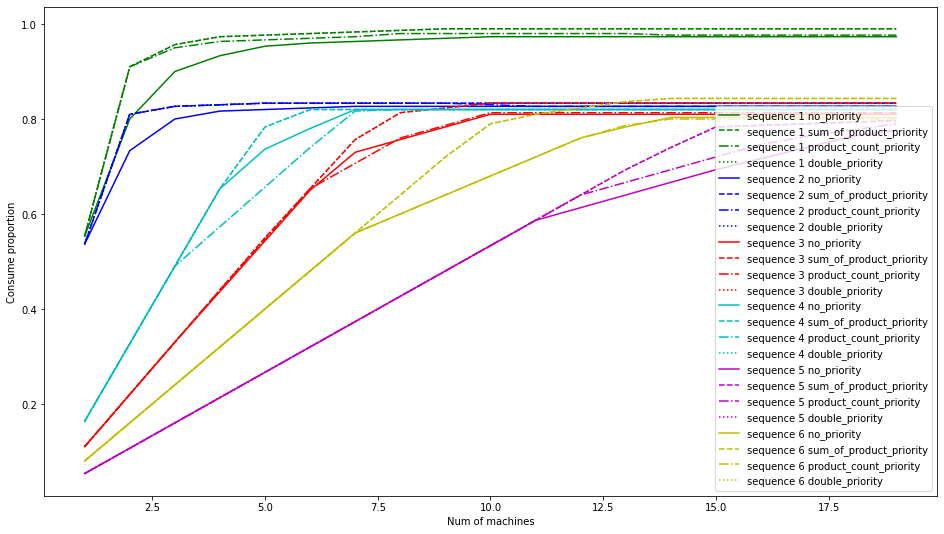

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

plt.plot(x, results_flush[0][0], "-g", label="sequence 1 no_priority")
plt.plot(x, results_flush[0][1], "--g", label="sequence 1 sum_of_product_priority")
plt.plot(x, results_flush[0][2], "-.g", label="sequence 1 product_count_priority")
plt.plot(x, results_flush[0][3], ":g", label="sequence 1 double_priority")

plt.plot(x, results_flush[1][0], "-b", label="sequence 2 no_priority")
plt.plot(x, results_flush[1][1], "--b", label="sequence 2 sum_of_product_priority")
plt.plot(x, results_flush[1][2], "-.b", label="sequence 2 product_count_priority")
plt.plot(x, results_flush[1][3], ":b", label="sequence 2 double_priority")

plt.plot(x, results_flush[2][0], "-r", label="sequence 3 no_priority")
plt.plot(x, results_flush[2][1], "--r", label="sequence 3 sum_of_product_priority")
plt.plot(x, results_flush[2][2], "-.r", label="sequence 3 product_count_priority")
plt.plot(x, results_flush[2][3], ":r", label="sequence 3 double_priority")

plt.plot(x, results_flush[3][0], "-c", label="sequence 4 no_priority")
plt.plot(x, results_flush[3][1], "--c", label="sequence 4 sum_of_product_priority")
plt.plot(x, results_flush[3][2], "-.c", label="sequence 4 product_count_priority")
plt.plot(x, results_flush[3][3], ":c", label="sequence 4 double_priority")

plt.plot(x, results_flush[4][0], "-m", label="sequence 5 no_priority")
plt.plot(x, results_flush[4][1], "--m", label="sequence 5 sum_of_product_priority")
plt.plot(x, results_flush[4][2], "-.m", label="sequence 5 product_count_priority")
plt.plot(x, results_flush[4][3], ":m", label="sequence 5 double_priority")

plt.plot(x, results_flush[5][0], "-y", label="sequence 6 no_priority")
plt.plot(x, results_flush[5][1], "--y", label="sequence 6 sum_of_product_priority")
plt.plot(x, results_flush[5][2], "-.y", label="sequence 6 product_count_priority")
plt.plot(x, results_flush[5][3], ":y", label="sequence 6 double_priority")


plt.xlabel("Num of machines")
plt.ylabel("Consume proportion")

plt.legend()
plt.show()